In [1]:
!python3 -m pip install karateclub

In [2]:
import numpy as np
import networkx as nx
from karateclub.node_embedding import node2vec

In [3]:
graph = nx.karate_club_graph()

In [4]:
m = node2vec.Node2Vec(dimensions=2)
m.fit(graph)

In [5]:
z = m.get_embedding()

In [6]:
A = np.array(nx.adj_matrix(graph).todense())
deg = A.sum(axis=1)
D_inv = np.diag(1 / deg)
D_12 = np.diag(np.sqrt(deg))
#L = D_12 @ (np.eye(len(A)) - A) @ D_12
L = np.diag(deg) - A

/tmp/ipykernel_136134/86968253.py:1: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  A = np.array(nx.adj_matrix(graph).todense())


In [7]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(2, affinity='precomputed', n_init=100)
sc.fit(A)
c = sc.fit_predict(A)

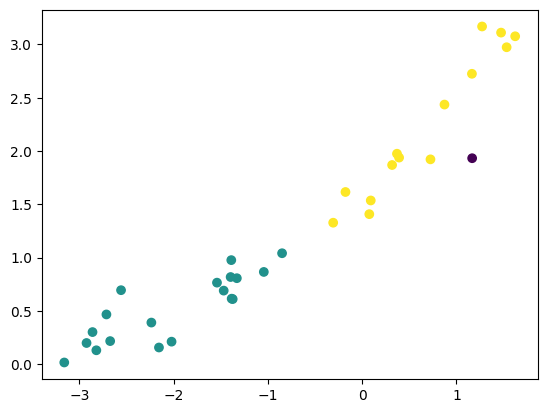

In [8]:
import matplotlib.pyplot as plt
c[0] = -1
plt.scatter(z[:, 0], z[:, 1], c=c)

(33, 33) (33, 2)
(33, 2) (33,)


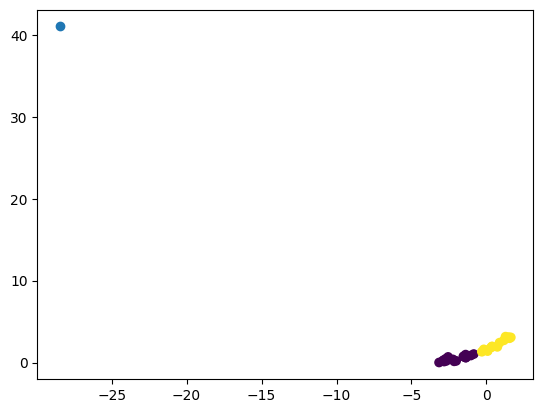

In [9]:
g2 = graph.copy()
g2.remove_node(0)
z2 = z[1:]
c2 = c[1:]
plt.scatter(z2[:, 0], z2[:, 1], c=c2)
A_ = L[1:,1:]
print(A_.shape, z2.shape)
f = np.linalg.solve(A_, z2)
print(f.shape, A[0,1:].shape)
y = A[1:,0].T @ f
plt.scatter([y[0]],[y[1]])

# Semi-Inductive DeepWalk

In [11]:
import torch
import torch.nn as nn
import torch.functional as F

In [167]:
class MyModel(nn.Module):

    def __init__(self, features, dim):
        super().__init__()
        self.features = features.float()
        self.lin = nn.Linear(self.features.shape[0], dim, bias=False)

    def embeddings_(self):
        return self.lin.weight.detach().clone().T

    def embed(self, x):
        vx = self.features[x]
        return self.lin(vx)

    def forward(self, a, b, use_sigmoid=True):
        va, vb = self.features[a], self.features[b]
        va, vb = self.lin(va), self.lin(vb)
        scores = (va * vb).sum(dim=1)
        if use_sigmoid:
            scores = torch.sigmoid(scores)
        return scores

In [168]:
from karateclub.utils import RandomWalker
from nltk import skipgrams
from functools import reduce

In [169]:
def gen_walks(walker, graph):
    walker.do_walks(graph)
    w = [[int(n) for n in wi] for wi in walker.walks]
    return w

def sg(walks, n=2, k=5):
    sgs = [list(skipgrams(w,n,k)) for w in walks]
    return torch.tensor(reduce(list.__add__, sgs))

def sample_pos(length, n_samples):
    walker = RandomWalker(length, n_samples)
    return sg(gen_walks(walker, graph), 2, 5)

def sample_neg(n):
    return torch.tensor(np.random.randint(0, len(graph), size=(n,)))

def sample(n, l):
    p = sample_pos(l, n)
    n = sample_neg(len(p))
    n = torch.stack((p[:,0], n), dim=1)
    x = torch.cat((p,n), dim=0)
    y = torch.cat((torch.ones(len(p)), torch.zeros(len(n))))
    return x, y

In [175]:
tA = torch.tensor(A)
#tA = torch.eye(len(graph))
m = MyModel(tA, 2)
opt = torch.optim.Adam(m.parameters(), 1e-3)

crit = nn.BCELoss()

hist = []
for i in range(800):
    if i % 100 == 0:
        print(i, np.mean(hist))
    x,y = sample(10,10)
    xa, xb = x[:, 0], x[:, 1]
    loss = crit(m(xa, xb), y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    hist.append(loss.item())

0 nan
100 0.6617404788732528
200 0.6448587039113045
300 0.6362185748418172
400 0.6315422281622887
500 0.6284948333501815
600 0.6263893490036329
700 0.6247726495776857


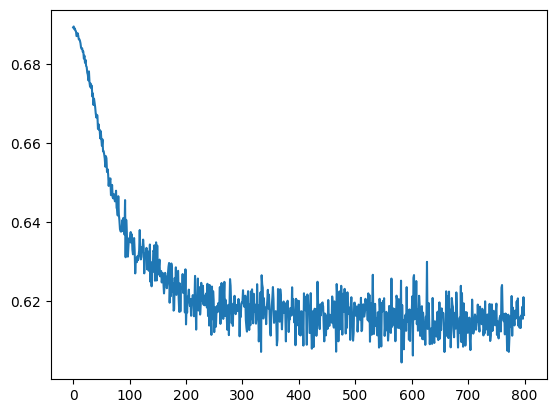

In [176]:
plt.plot(hist)

tensor([0.5239, 0.4247])


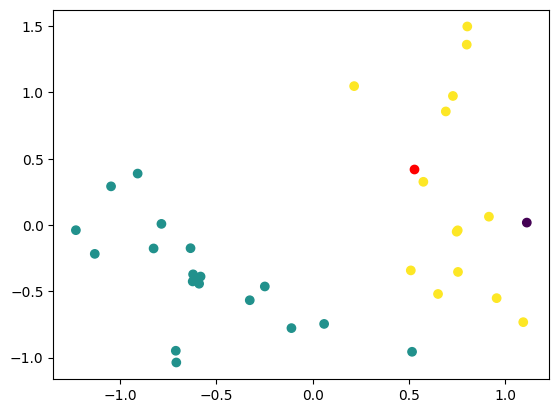

In [184]:
qq = torch.arange(34)
z3 = m.embed(qq).detach()

plt.scatter(z3[:, 0], z3[:, 1], c=c)

qq2 = torch.zeros((1,34))
qq2[0,0] = 1
qq2[0,5] = 1
z4 = m.lin(qq2)[0].detach()
print(z4)
plt.scatter([z4[0]], [z4[1]], c="red")